# Input Processing

In [29]:
from IPython.display import display
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath
import wfdb
from wfdb import processing

## Settings 

In [19]:
data_path = '../data/files/'
record_name = '04043'

## WFDB record:

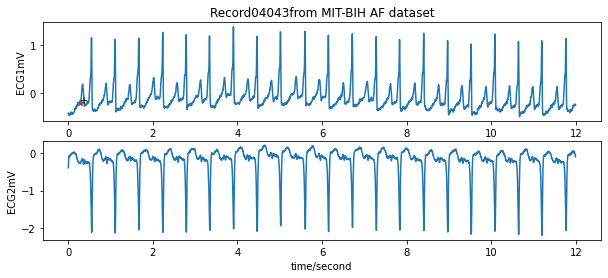

{'record_name': '04043',
 'n_sig': 2,
 'fs': 250,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 3000,
 'base_time': datetime.time(15, 0),
 'base_date': None,
 'comments': [],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': array([[-0.415, -0.395],
        [-0.415, -0.26 ],
        [-0.43 , -0.185],
        ...,
        [-0.235, -0.065],
        [-0.245, -0.09 ],
        [-0.24 , -0.1  ]]),
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['04043.dat', '04043.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-83, -79],
 'checksum': [8676, 9694],
 'block_size': [0, 0]}

In [20]:
record = wfdb.rdrecord(data_path + record_name, sampto=3000)
ann = wfdb.rdann(data_path + record_name, 'atr', sampto=3000)
wfdb.plot_wfdb(record=record, title='Record' + record_name + 'from MIT-BIH AF dataset',
               annotation=ann,
               plot_sym=True,
               time_units='seconds',
               figsize=(10,4)) 
display(record.__dict__)

In [21]:
# Read a WFDB header file only (without the signals)
record = wfdb.rdheader(data_path + record_name)
display(record.__dict__)

{'record_name': '04043',
 'n_sig': 2,
 'fs': 250,
 'counter_freq': None,
 'base_counter': None,
 'sig_len': 9205760,
 'base_time': datetime.time(15, 0),
 'base_date': None,
 'comments': [],
 'sig_name': ['ECG1', 'ECG2'],
 'p_signal': None,
 'd_signal': None,
 'e_p_signal': None,
 'e_d_signal': None,
 'file_name': ['04043.dat', '04043.dat'],
 'fmt': ['212', '212'],
 'samps_per_frame': [1, 1],
 'skew': [None, None],
 'byte_offset': [None, None],
 'adc_gain': [200.0, 200.0],
 'baseline': [0, 0],
 'units': ['mV', 'mV'],
 'adc_res': [12, 12],
 'adc_zero': [0, 0],
 'init_value': [-83, -79],
 'checksum': [3080, -14988],
 'block_size': [0, 0]}

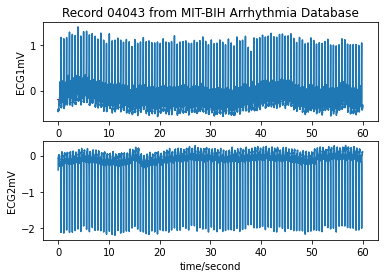

In [27]:
# Read a WFDB record and annotation. Plot all channels, and the annotation on top of channel 0.
record = wfdb.rdrecord(data_path + record_name, sampto = 15000)
annotation = wfdb.rdann(data_path + record_name, 'atr', sampto = 15000)

wfdb.plot_wfdb(record=record, annotation=annotation,
               title='Record '+ record_name  +' from MIT-BIH Arrhythmia Database',
               time_units='seconds')

## ECG Processing

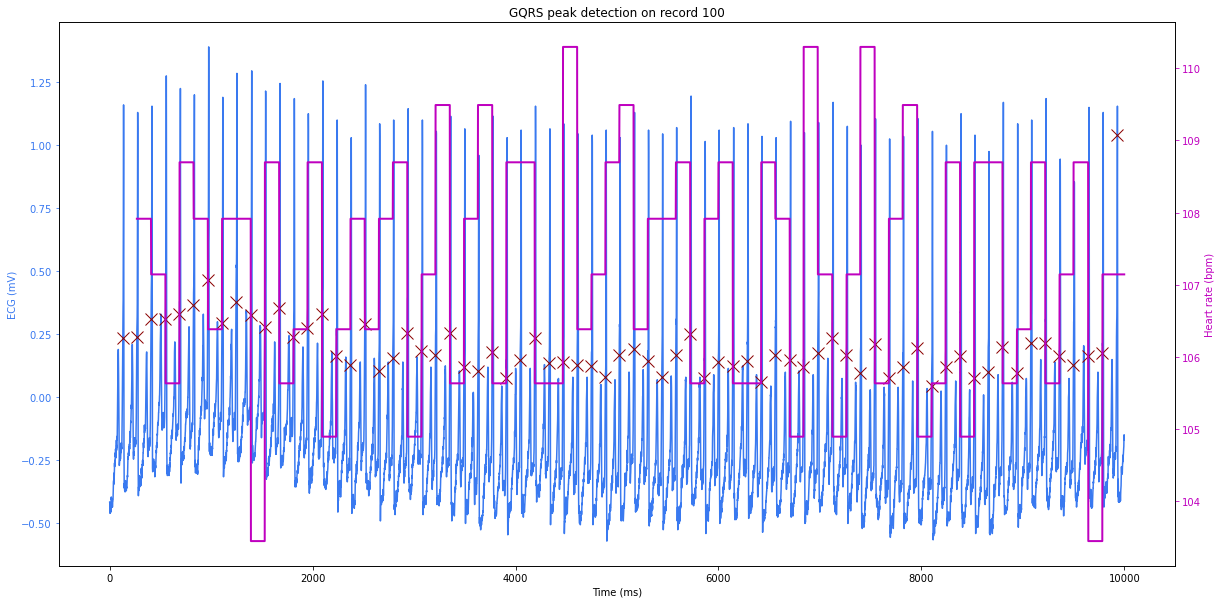

Corrected GQRS detected peak indices: [137, 276, 417, 558, 697, 835, 976, 1115, 1254, 1400, 1537, 1679, 1820, 1958, 2101, 2242, 2381, 2522, 2661, 2799, 2942, 3082, 3219, 3361, 3500, 3638, 3779, 3917, 4055, 4197, 4339, 4475, 4616, 4756, 4894, 5031, 5173, 5311, 5450, 5588, 5730, 5869, 6007, 6149, 6291, 6429, 6568, 6711, 6847, 6987, 7130, 7270, 7406, 7548, 7687, 7824, 7967, 8109, 8247, 8391, 8528, 8666, 8808, 8949, 9087, 9229, 9368, 9507, 9652, 9792, 9932]


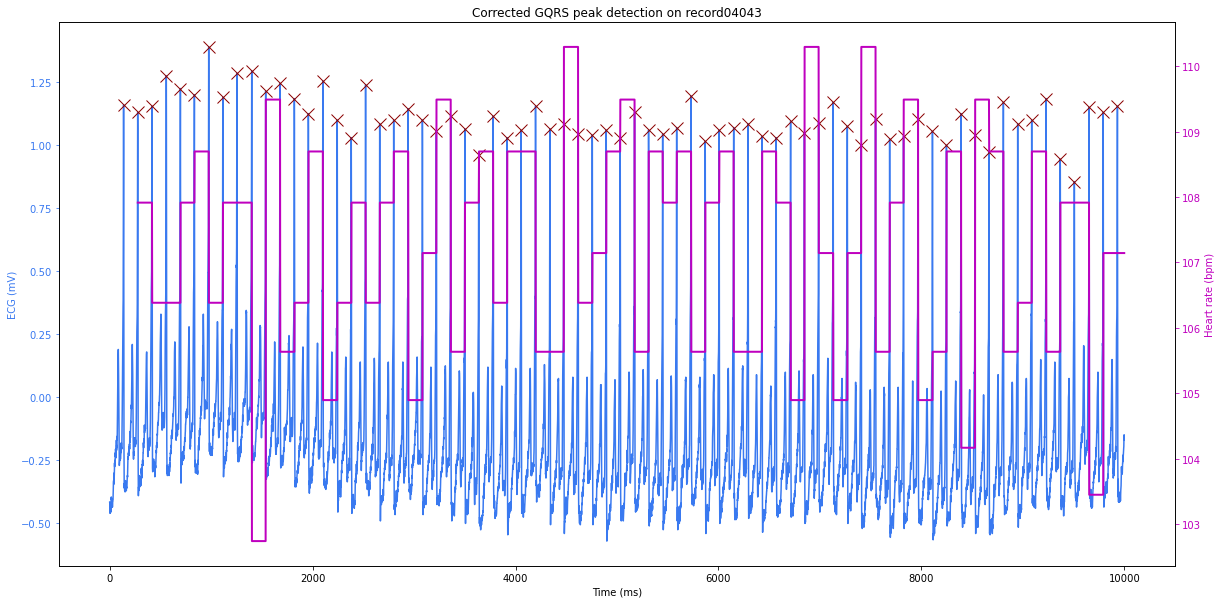

In [33]:
# Use the GQRS detection algorithm and correct the peaks

def peaks_hr(sig, peak_inds, fs, title, figsize=(20, 10), saveto=None):
    "Plot a signal with its peaks and heart rate"
    # Calculate heart rate
    hrs = processing.hr.compute_hr(sig_len=sig.shape[0], qrs_inds=peak_inds, fs=fs)
    
    N = sig.shape[0]
    
    fig, ax_left = plt.subplots(figsize=figsize)
    ax_right = ax_left.twinx()
    
    ax_left.plot(sig, color='#3979f0', label='Signal')
    ax_left.plot(peak_inds, sig[peak_inds], 'rx', marker='x', 
                 color='#8b0000', label='Peak', markersize=12)
    ax_right.plot(np.arange(N), hrs, label='Heart rate', color='m', linewidth=2)

    ax_left.set_title(title)

    ax_left.set_xlabel('Time (ms)')
    ax_left.set_ylabel('ECG (mV)', color='#3979f0')
    ax_right.set_ylabel('Heart rate (bpm)', color='m')
    # Make the y-axis label, ticks and tick labels match the line color.
    ax_left.tick_params('y', colors='#3979f0')
    ax_right.tick_params('y', colors='m')
    if saveto is not None:
        plt.savefig(saveto, dpi=600)
    plt.show()

# Load the WFDB record and the physical samples
record = wfdb.rdrecord(data_path + record_name, sampfrom=0, sampto=10000, channels=[0])

# Use the GQRS algorithm to detect QRS locations in the first channel
qrs_inds = processing.qrs.gqrs_detect(sig=record.p_signal[:,0], fs=record.fs)

# Plot results
peaks_hr(sig=record.p_signal, peak_inds=qrs_inds, fs=record.fs,
         title="GQRS peak detection on record 100")
    
# Correct the peaks shifting them to local maxima
min_bpm = 20
max_bpm = 230
#min_gap = record.fs * 60 / min_bpm
# Use the maximum possible bpm as the search radius
search_radius = int(record.fs * 60 / max_bpm)
corrected_peak_inds = processing.peaks.correct_peaks(record.p_signal[:,0], 
                                                     peak_inds=qrs_inds,
                                                     search_radius=search_radius, 
                                                     smooth_window_size=150)

# Display results
print('Corrected GQRS detected peak indices:', sorted(corrected_peak_inds))
peaks_hr(sig=record.p_signal, peak_inds=sorted(corrected_peak_inds), fs=record.fs,
         title="Corrected GQRS peak detection on record" + record_name)
    

In [34]:
# Use the XQRS detection algorithm and compare results to reference annotations
import wfdb
from wfdb import processing
sig, fields = wfdb.rdsamp(data_path + record_name, channels=[0], sampto=15000)
ann_ref = wfdb.rdann(data_path + record_name, 'atr', sampto=15000)

# Run QRS detection on signal
xqrs = processing.XQRS(sig=sig[:,0], fs=fields['fs'])
xqrs.detect()
# Alternatively, use the gateway function to get the QRS indices directly
# qrs_inds = processing.xqrs_detect(sig=sig[:,0], fs=fields['fs'])

# Compare detected QRS complexes to reference annotation.
# Note, first sample in 100.atr is not a QRS.
comparitor = processing.compare_annotations(ref_sample=ann_ref.sample[1:],
                                            test_sample=xqrs.qrs_inds,
                                            window_width=int(0.1 * fields['fs']),
                                            signal=sig[:,0])

# Print and plot the results
comparitor.print_summary()
comparitor.plot(title='xqrs detected QRS vs reference annotations')

Learning initial signal parameters...
Found 8 beats during learning. Initializing using learned parameters
Running QRS detection...
QRS detection complete.


ValueError: min() arg is an empty sequence